In [1]:
import math
import numpy as np
import sympy as sym
import scipy.special
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp2d
%matplotlib inline
from scipy.integrate import cumtrapz

In [2]:
# n: number density
n=sym.symbols('n')

In [3]:
# rs: 3D Wigner-Seitz parameter
def n_from_rs(rs):
    return 3./(4*math.pi*rs*rs*rs) # 3D

In [4]:
### Exchange energy per particle
# Carsten A. Ullrich and Zeng-hui Yang, 
# A Brief Compendium of Time-Dependent Density Functional Theory 
# Braz J Phys (2014) 44:154–188, Eq.(34)
axfactor=-(3/4.)*(3/math.pi)**(1/3.)
def ex(n):
    return axfactor*n**(1/3.) # per particle

In [5]:
### Correlation: Chachiyo-Karasiev parametrization
acfactor=(math.log(2.)-1.)/(2.*math.pi**2)
n2invrs=(4.*math.pi/3)**(1/3.)
def ec(n):
    invrs = n2invrs*n**(1/3.) 
    return acfactor*sym.log( 1. + 21.7392245*invrs + 20.4562557*invrs**2 )

In [6]:
def exc(n):
    return ex(n)+ec(n)
np_exc=sym.lambdify(n, exc(n), 'numpy')

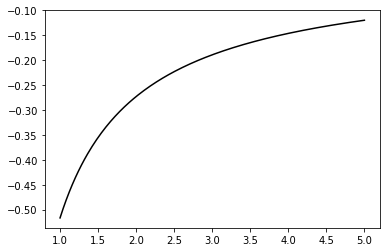

In [7]:
rsrange=np.linspace(1,5,200)
nrange=n_from_rs(rsrange)
fig,ax=plt.subplots()
ax.plot(rsrange,np_exc(nrange),'k')

In [8]:
f0=sym.diff(n*exc(n),n,2) # Eq.(i) GK
#finf=-(4/5.)*n**(2/3.)*sym.diff(exc(n)*n**(-2/3.)) # Eq.(ii) GK
finf=-(4/5.)*n**(2/3.)*sym.diff(exc(n)*n**(-2/3.)) + 6.*n**(1/3.)*sym.diff(exc(n)*n**(-1/3.)) # Eq.(2) Iwamoto
np_f0=sym.lambdify(n, f0, 'numpy')
np_finf=sym.lambdify(n, finf, 'numpy')
np_finf_f0=sym.lambdify(n, finf-f0, 'numpy')

In [9]:
gamma=math.gamma(1/4.)**2/math.sqrt(32*math.pi) # Eq.(17) GK+Errata

In [10]:
c=23*math.pi/15. # GK Eq.(13)

In [11]:
gamma_over_c = gamma/c # from Eq.(13) GK

In [12]:
def Imfxc(n,omega):
    a=-c*(gamma_over_c*np_finf_f0(n))**(5/3.) # GK Eq.(16)+Errata
    b=(gamma_over_c*np_finf_f0(n))**(4/3.) # GK Eq.(17)
    return a*omega/(1.+b*omega*omega)**(5/4.)

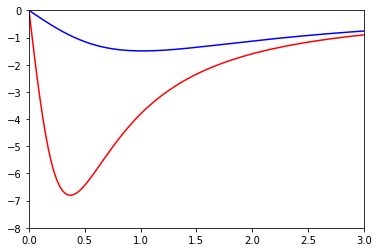

In [13]:
omegarange=np.linspace(0,5,200)
fig,ax=plt.subplots()
#ax.set_xlim([0,5]) # GK
#ax.set_ylim([-2.5,0]) # GK
ax.set_xlim([0,3])# Iwamoto
ax.set_ylim([-8,0]) # Iwamoto
ax.plot(omegarange,Imfxc(n_from_rs(2),omegarange),'b')
ax.plot(omegarange,Imfxc(n_from_rs(4),omegarange),'r')

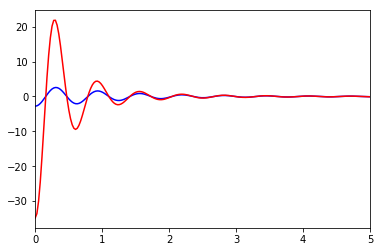

In [14]:
omegarange=np.linspace(0.0001,5,200)
tau=10
fig,ax=plt.subplots()
ax.set_xlim([0,5])
ax.plot(omegarange,Imfxc(n_from_rs(2),omegarange)*np.cos(omegarange*tau)/omegarange,'b')
ax.plot(omegarange,Imfxc(n_from_rs(4),omegarange)*np.cos(omegarange*tau)/omegarange,'r')

In [15]:
def integrand_without_cos(omega,n,tau):
    return Imfxc(n,omega)/omega

In [16]:
def cosintegral(n,tau):
    return 2.*quad(integrand_without_cos,1.e-10,math.inf,args=(n,tau),weight='cos',wvar=tau)[0]

In [17]:
n_from_rs(5)

0.0019098593171027439

In [18]:
n0=1.e-5
n0**(2/3)*cosintegral(n0,1)

-0.9574359368597054

In [19]:
#%timeit cosintegral(n_from_rs(4),1)

In [20]:
def KK_integrand(omega1,n):
    return Imfxc(n,omega1)

def Refxc(n,omega):
    #KKintegral=quad(KK_integrand,-500,500,args=(n,),limit=200,weight='cauchy',wvar=omega,points=[omega])[0]
    KKintegral=quad(KK_integrand,-1000,1000,args=(n,),limit=200,weight='cauchy',wvar=omega,points=[omega])[0]
    return np_finf(n)+KKintegral/math.pi

np_Refxc=np.vectorize(Refxc)

In [21]:
# ### Test: Fig.1 Iwamoto
# omegarange=np.linspace(0,5,20)
# fig,ax=plt.subplots()
# #ax.set_xlim([0,5]) # GK
# ax.set_xlim([0,3]) # Iwamoto
# ax.set_ylim([-17,0])
# ax.plot(omegarange,np_Refxc(n_from_rs(2),omegarange),'b.')
# ax.plot(omegarange,np_Refxc(n_from_rs(4),omegarange),'r.')

In [22]:
nexc2=sym.diff(n*exc(n),n,2)
np_nexc2=sym.lambdify(n, nexc2, 'numpy')

In [23]:
def muxc(n):
    return (3/4.)*n*n*(Refxc(n,0)-np_nexc2(n))

In [24]:
### ykernel: Y/n**2
def ykernel(n,tau):
#    return (3/4.)*(Refxc(n,0)-np_nexc2(n))-cosintegral(n,tau)/math.pi
    return -cosintegral(n,tau)/math.pi
np_y=np.vectorize(ykernel)

In [25]:
Y0=-(20/3.)*n*exc(n)+(26/5.)*n*sym.diff(n*exc(n))-n*n*sym.diff(n*exc(n),n,2)
np_Y0=sym.lambdify(n, Y0, 'numpy')

In [26]:
np_Y0(n_from_rs(4))

0.00016748743915599284

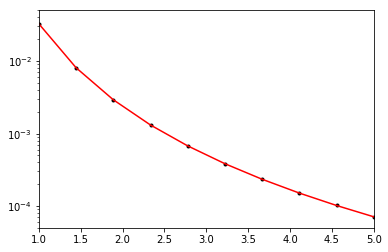

In [27]:
rsrange=np.linspace(1,5,10)
nrange=n_from_rs(rsrange)
fig,ax=plt.subplots()
ax.set_xlim([1,5])
ax.set_ylim([5e-5,5e-2])
ax.semilogy(rsrange,nrange**2*np_y(nrange,0),'k.')
ax.semilogy(rsrange,np_Y0(nrange),'r')

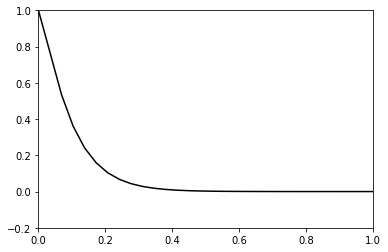

In [28]:
def Tp(n):
    omegap=math.sqrt(4.*math.pi*n)
    return 2.*math.pi/omegap
    #return 0.5*2.*math.pi/omegap # agrees better ???

rs0=5.
n0=n_from_rs(rs0)
tau=np.linspace(0.,Tp(n0),30)
fig,ax=plt.subplots()
ax.set_xlim(0,1)
ax.set_ylim(-0.2,1)
ax.plot(tau/Tp(n0),np_y(n0,tau)/np_y(n0,0),'k');

## 2QWell

In [29]:
N=1.; L=8.; avomp=math.sqrt(32*N/(math.pi*L)); # Eq.(57) Ullrich

In [30]:
A=0.005; omega=2.22*avomp; T=2*math.pi/omega;

Рассмотрим гауссовскую плотность:
\begin{equation}
n(x,t)=\frac{1}{\sqrt{\pi}}e^{-(x+1)^2}\sin^2(\omega\frac{t}{2})+\frac{1}{\sqrt{\pi}}e^{-(x-1)^2}\cos^2(\omega\frac{t}{2})
\end{equation}

In [31]:
def v(xi,t):
    return A*omega*xi*np.cos(omega*t)

def gradv(t):
    return A*omega*np.cos(omega*t)

def g1(t):
    return (np.sin(omega*t/2)**2)
def g2(t):
    return (np.cos(omega*t/2)**2)
def g_dif1(t):
    return (np.sin(omega*t/2)*2*np.cos(omega*t/2)*omega/2)
def g_dif2(t):
    return -g_dif1(t)#np.cos(omega*t/2)*2*np.sin(omega*t/2)*omega/2
def f1(x):
    return np.exp(-(x+1)**2)
def f2(x):
    return np.exp(-(x-1)**2)
def nr(x,t):
    return (f1(x)*g1(t)+f2(x)*g2(t))/np.sqrt(math.pi)

# def nbreather(x,t):
#     sqrtavg=1./(1+A*np.sin(omega*t))
#     if abs(x)<=(L/2.)*(1+A*np.sin(omega*t)):
#         return (2.*N/L)*sqrtavg*np.cos(sqrtavg*math.pi*x/L)**2
#     else:
#         return 0.

# x -- 1D numpy array
def nbreather(x,t):
    return f1(x)*g1(t)+f2(x)*g2(t)



In [32]:
S=3*T

1

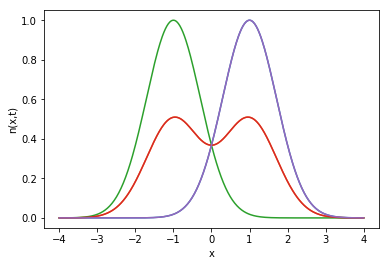

In [33]:
nmax=1
xrange=np.linspace(-4,4,400)
fig,ax=plt.subplots()
#ax.set_xlim([-(1+A)*L/2,(1+A)*L/2])
#ax.set_ylim([0,nmax])
ax.set_ylabel(u'n(x,t)')
ax.set_xlabel(u'x')
ax.plot(xrange,nbreather(xrange,0*T/4))
ax.plot(xrange,nbreather(xrange,1*T/4))
ax.plot(xrange,nbreather(xrange,2*T/4))
ax.plot(xrange,nbreather(xrange,3*T/4))
ax.plot(xrange,nbreather(xrange,4*T/4))
nmax

Найдем скорость по формуле
\begin{equation}
v(x,t)=-\frac{1}{n(x,t)}\frac{\partial}{\partial t}\int_0^xn(x',t)dx'
\end{equation}

In [34]:
x = np.linspace(-4, 4, 50)
def f_dif1(x):
    return -2*(x+1)*np.exp(-(x+1)**2)
def f_dif2(x):
    return -2*(x-1)*np.exp(-(x-1)**2)
y=f1(x)
y2=f2(x)



In [35]:
h=x[1]-x[0]

In [36]:
def B2(t):
    return cumtrapz(y, x, initial=0)*g_dif1(t)+cumtrapz(y2, x,  initial=0)*g_dif2(t)
def v(t):
   
    return -B2(t)/(y*g1(t)+y2*g2(t))

Построим график числителя в выражении для скорость, чтобы понимать вид графика для скорости

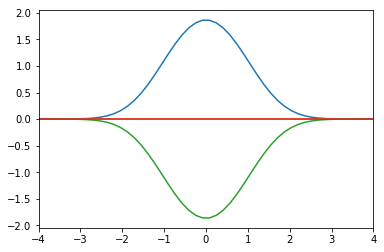

In [37]:


#ax.set_ylim([0,nmax])
fig,ax=plt.subplots()
ax.set_xlim([-4,4])
ax.plot(x,B2(T/4*1))
ax.plot(x,B2(T/4*2))
ax.plot(x,B2(T/4*3))
ax.plot(x,B2(T/4*4))
#ax.plot(xrange,nbreather(xrange,1*T/4))
#ax.plot(xrange,nbreather(xrange,2*T/4))
#ax.plot(xrange,nbreather(xrange,3*T/4))
#ax.plot(xrange,nbreather(xrange,4*T/4))



Градиент скоркости найдем из уравнения
\begin{equation}
\nabla_xv(x,t)=-\frac{1}{n(x,t)}\frac{\partial}{\partial t}n(x,t)+\frac{\partial_xn(x,t)}{n^2(x,t)}\partial_t\int_0^xn(x',t)dx'
\end{equation}

In [38]:
def a(t):
    return y*g1(t)+y2*g2(t)
y_dif=f_dif1(x)
y2_dif=f_dif2(x)
def v_dif(t):
    return -1/a(t)*(y*g_dif1(t)+y2*g_dif2(t))+(y_dif*g1(t)+y2_dif*g2(t))/a(t)/a(t)*B2(t)
#1/a(t)*(y*g_dif1(t)+y2*g_dif2(t))
#def gradv(t):
 #   return v_dif(t)


In [39]:
def gradv(t):
#    return np.gradient(v(t),h)
    return v_dif(t)



Распределение скорости имеет следующий вид

1

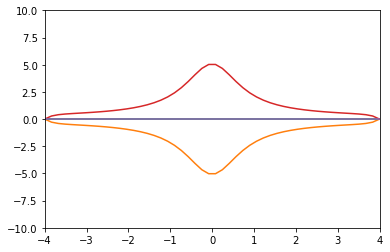

In [40]:
nmax=1
#x = np.linspace(0, 12, 51)
#xrange=np.linspace(0,9,400)
fig,ax=plt.subplots()

ax.set_xlim([-4,4])
ax.set_ylim([-10,10])
ax.plot(x,v(0*T/4))
ax.plot(x,v(1*T/4))
ax.plot(x,v(2*T/4))
ax.plot(x,v(3*T/4))
ax.plot(x,v(4*T/4))
nmax

Для проверки построим график градиента скорости.

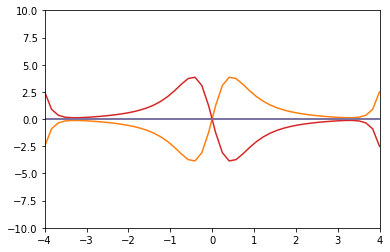

In [41]:
fig,ax=plt.subplots()
ax.set_xlim([-4,4])
ax.set_ylim([-10,10])
ax.plot(x,gradv(T/4*0))
ax.plot(x,gradv(T/4*1))
ax.plot(x,gradv(T/4*2))
ax.plot(x,gradv(T/4*3))
ax.plot(x,gradv(T/4*4))

In [42]:
nrange=np.linspace(1.e-8,1,200)
trange=np.linspace(0.,T,10)
nnrange,ttrange = np.meshgrid(nrange,trange,indexing='xy')

In [43]:
%time ydata=np_y(nnrange,ttrange)

CPU times: user 9.39 s, sys: 57.5 ms, total: 9.45 s
Wall time: 9.54 s


In [44]:
yint=interp2d(nrange, trange, ydata, kind='cubic')

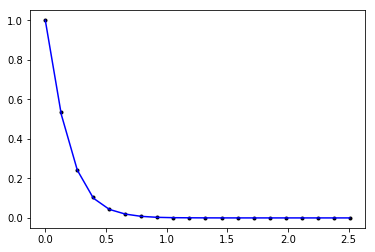

In [45]:
n0=1
tau=np.linspace(0.,T,20)
fig,ax=plt.subplots()
#ax.set_xlim(0,1)
#ax.set_ylim(-0.2,1)
ax.plot(tau,np_y(n0,tau)/np_y(n0,0),'k.');
ax.plot(tau,yint(n0,tau)/yint(n0,0),'b');

Найме значение потенциала с помощью формулы
\begin{equation}
V_{xc}^M=-n(x,t)\frac{\sigma_{xc,xx}(x,t)}{n^2(x,t)}+n(0,t)\frac{\sigma_{xc,xx}(0,t)}{n^2(0,t)}-\int_0^x\frac{\sigma_{xc,xx}(x',t)}{n^2(x',t)}\partial_{x'}n(x',t)dx'
\end{equation}

In [46]:
x = np.linspace(-4, 4, 50)
h=x[1]-x[0]
### sxc = sigma_xc/n**2
def sxc_integrand_2(t1,t,k):
    return yint(nbreather(k*h,t),t-t1)*gradv(t1)[k]

def sxc2(t,k):
    return quad(sxc_integrand_2,0,t,args=(t,k))[0]



#np_sxc=np.vectorize(sxc)

In [47]:
K=25
S=-0*T

In [48]:
sxc_0=np.zeros((K))
sxc_1=np.zeros((K))
sxc_2=np.zeros((K))
sxc_3=np.zeros((K))
sxc_4=np.zeros((K))
for n in range (0,K):
    sxc_0[n]= (sxc2(3*T+0*T/4+S,n))
    sxc_1[n]= (sxc2(3*T+1*T/4+S,n))
    sxc_2[n]= (sxc2(3*T+2*T/4+S,n))
    sxc_3[n]= (sxc2(3*T+3*T/4+S,n))
    sxc_4[n]= (sxc2(3*T+4*T/4+S,n))


    

/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [49]:
#def n_dif(x,t):
 #   return -2*N/L/(1+np.sin(omega*t))*2*np.cos(math.pi*x/L/(1+A*np.sin(omega*t)))*np.sin(math.pi*x/L/(1+A*np.sin(omega*t)))*math.pi/L/(1+A*np.sin(omega*t))
def n_dif(x,t):
    return f_dif1(x)*g1(t)+f_dif2(x)*g2(t)
x = np.linspace(0, 4, K)
nd_0=np.zeros((K))
nd_1=np.zeros((K))
nd_2=np.zeros((K))
nd_3=np.zeros((K))
nd_4=np.zeros((K))
for n in range (0,K):
    nd_0[n]=n_dif(x[n],3*T+0*T/4+S)
    nd_1[n]=n_dif(x[n],3*T+1*T/4+S)
    nd_2[n]=n_dif(x[n],3*T+2*T/4+S)
    nd_3[n]=n_dif(x[n],3*T+3*T/4+S)
    nd_4[n]=n_dif(x[n],3*T+4*T/4+S)


           
    
    
    
    
n_0=np.zeros((K))
n_1=np.zeros((K))
n_2=np.zeros((K))
n_3=np.zeros((K))
n_4=np.zeros((K))
for n in range (0,K):
    n_0[n]=nbreather(x[n],3*T+0*T/4+S)
    n_1[n]=nbreather(x[n],3*T+1*T/4+S)
    n_2[n]=nbreather(x[n],3*T+2*T/4+S)
    n_3[n]=nbreather(x[n],3*T+3*T/4+S)
    n_4[n]=nbreather(x[n],3*T+4*T/4+S)     



    
        
    


In [50]:
from scipy.integrate import simps
x = np.linspace(0, 4, K)
I_0 = cumtrapz(nd_0*sxc_0, x, initial=0)
I_1 = cumtrapz(nd_1*sxc_1, x, initial=0)
I_2 = cumtrapz(nd_2*sxc_2, x, initial=0)
I_3 = cumtrapz(nd_3*sxc_3, x, initial=0)
I_4 = cumtrapz(nd_4*sxc_4, x, initial=0)

In [51]:
J_0=-n_0[0]*sxc_0[0]
J_1=-n_1[0]*sxc_1[0]
J_2=-n_2[0]*sxc_2[0]
J_3=-n_3[0]*sxc_3[0]
J_4=-n_4[0]*sxc_4[0]

In [52]:
#def Vxc_integrand(n,t):
 #   return sxcint(n,t)

#def Vxc(n,t):
 #   return -n*sxcint(n,t) - quad(Vxc_integrand,1.e-8,n,args=(t,))[0]

#np_Vxc=np.vectorize(Vxc)

V_0=(-n_0*sxc_0-I_0-J_0)
V_1=(-n_1*sxc_1-I_1-J_1)
V_2=(-n_2*sxc_2-I_2-J_2)
V_3=(-n_3*sxc_3-I_3-J_3)
V_4=(-n_4*sxc_4-I_4-J_4)

Строим потенциал для различных времен. V_0 и V_4, соответствующие $t=2T$ и $t=3T$ соответственно, совпадают.

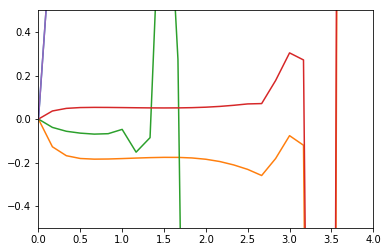

In [53]:
nmax=1
#x = np.linspace(0, 12, 51)

fig,ax=plt.subplots()
ax.set_xlim([0,4])
ax.set_ylim([-0.5,0.5])
ax.plot(x,V_0)
ax.plot(x,V_1)
ax.plot(x,V_2)
ax.plot(x,V_3)
ax.plot(x,V_4)


In [54]:
x = np.linspace(-4, 4, 50)
h=x[1]-x[0]
### sxc = sigma_xc/n**2
def sxc_integrand_2(t1,t,k):
    return yint(nbreather(k*h,t),t-t1)*gradv(t1)[k]

def sxc2(t,k):
    return quad(sxc_integrand_2,0,t,args=(t,k))[0]



In [55]:
sxc_0=np.zeros((K))
sxc_1=np.zeros((K))
sxc_2=np.zeros((K))
sxc_3=np.zeros((K))
sxc_4=np.zeros((K))
for n in range (K,50):
    sxc_0[n-K]= (sxc2(3*T+0*T/4+S,n))
    sxc_1[n-K]= (sxc2(3*T+1*T/4+S,n))
    sxc_2[n-K]= (sxc2(3*T+2*T/4+S,n))
    sxc_3[n-K]= (sxc2(3*T+3*T/4+S,n))
    sxc_4[n-K]= (sxc2(3*T+4*T/4+S,n))

KeyboardInterrupt: 

In [ ]:
def n_dif(x,t):
    return f_dif1(x)*g1(t)+f_dif2(x)*g2(t)
x = np.linspace(0, 4, K)
nd_0=np.zeros((K))
nd_1=np.zeros((K))
nd_2=np.zeros((K))
nd_3=np.zeros((K))
nd_4=np.zeros((K))
for n in range (0,K):
    nd_0[n]=n_dif(x[n],3*T+0*T/4+S)
    nd_1[n]=n_dif(x[n],3*T+1*T/4+S)
    nd_2[n]=n_dif(x[n],3*T+2*T/4+S)
    nd_3[n]=n_dif(x[n],3*T+3*T/4+S)
    nd_4[n]=n_dif(x[n],3*T+4*T/4+S)


           
    
    
    
    
n_0=np.zeros((K))
n_1=np.zeros((K))
n_2=np.zeros((K))
n_3=np.zeros((K))
n_4=np.zeros((K))
for n in range (0,K):
    n_0[n]=nbreather(x[n],3*T+0*T/4+S)
    n_1[n]=nbreather(x[n],3*T+1*T/4+S)
    n_2[n]=nbreather(x[n],3*T+2*T/4+S)
    n_3[n]=nbreather(x[n],3*T+3*T/4+S)
    n_4[n]=nbreather(x[n],3*T+4*T/4+S)     

In [ ]:
x = np.linspace(0, 4, 25)
I_0 = cumtrapz(nd_0*sxc_0, x, initial=0)
I_1 = cumtrapz(nd_1*sxc_1, x, initial=0)
I_2 = cumtrapz(nd_2*sxc_2, x, initial=0)
I_3 = cumtrapz(nd_3*sxc_3, x, initial=0)
I_4 = cumtrapz(nd_4*sxc_4, x, initial=0)

J_0=sxc_0[0]*nd_0[0]-n_0[0]*sxc_0[0]
J_1=sxc_1[0]*nd_1[0]-n_1[0]*sxc_1[0]
J_2=sxc_2[0]*nd_2[0]-n_2[0]*sxc_2[0]
J_3=sxc_3[0]*nd_3[0]-n_3[0]*sxc_3[0]
J_4=sxc_4[0]*nd_4[0]-n_4[0]*sxc_4[0]

V_0=(-n_0*sxc_0-I_0-J_0)
V_1=(-n_1*sxc_1-I_1-J_1)
V_2=(-n_2*sxc_2-I_2-J_2)
V_3=(-n_3*sxc_3-I_3-J_3)
V_4=(-n_4*sxc_4-I_4-J_4)

In [ ]:
nmax=1
#x = np.linspace(0, 12, 51)

fig,ax=plt.subplots()
#ax.set_xlim([0,4])
#ax.set_ylim([-0.05,0.5])
ax.plot(x,V_0)
ax.plot(x,V_1)
ax.plot(x,V_2)
ax.plot(x,V_3)
ax.plot(x,V_4)

